# Inferential Analysis



*Build an analysis to address the highest profit for the next direct marketing* 
*campaign (sixth) which aims at selling a new gadget.*

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from scipy import stats


import psutil
import warnings
from sinfo import sinfo

warnings.filterwarnings("ignore")
plt.rcdefaults()

In [2]:
class WinsorizedMeanCalculator:
    def __init__(self, lower_percentile=0.05, upper_percentile=0.95):
        """
            Winsorized Mean (5%)
            ---
            Args:
                lower_percentile=0.05
                upper_percentile=0.95
            ---
            The k% winsorized mean is obtained by calculating the 
            arithmetic mean after replacing the k% of the smallest values 
            by the smallest value of the remaining values and the k% of the 
            largest values by the largest value of the remaining values.
        """
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile

    def winsorize(self, data):
        lower_limit = np.percentile(data, self.lower_percentile * 100)
        upper_limit = np.percentile(data, self.upper_percentile * 100)

        # Replace extreme values with the adjacent limits
        data = np.where(data < lower_limit, lower_limit, data)
        data = np.where(data > upper_limit, upper_limit, data)

        return data

    def calcu_winsor_mean(self, column):
        winsorized_data = self.winsorize(column)
        return np.mean(winsorized_data)

winsor = WinsorizedMeanCalculator()

def range(col):
    return col.max() - col.min()

def ksfunc(col):
    return stats.kstest(col, stats.norm.cdf,
                        args=(col.mean(), col.std()))

def cdv(col):
    """
        Coefficient of Variation Centered on the Mean.
        ---
        (std / mean) * 100
        ---
        Reasonable dispersion is associated with coefficients of variation 
        less than 50. Coefficients of variation greater than 50 indicate a 
        lot of dispersion. Coefficients greater than 100 are generally 
        indicative of strong anomalies in the data.
    """
    return (col.std() / abs(col.mean())) * 100

def trimean(series):
    """
        BESA (best easy systematic average)
        ---
        (Q1 + 2*Q2 + Q3) / 4
        ---
        Highly robust central tendency statistic
    """
    Q1 = series.quantile(0.25)
    median = series.median()
    Q3 = series.quantile(0.75)
    return (Q1 + 2 * median + Q3) / 4


In [3]:
# Storing path
path = Path("../data/ifood_cleaned.csv")

# Read CSV with pandas
data = pd.read_csv(path)

# Read columns dtypes
with open('../data/cleaned_dtypes.json', 'r') as f:
    data_types = json.load(f)

data = data.astype(data_types)

In [4]:
data["MntTotal_cat"], intervals = pd.cut(data["MntSpentTotal"], 6, 
                                         precision=0, retbins=True)

temp, first_int = pd.cut(np.arange(2, 426), 5, retbins=True)
bins = list(first_int) + list(intervals[2:])

data["MntTotal_cat"], intervals = pd.cut(data["MntSpentTotal"], bins, 
                                         precision=0, right=False, 
                                         retbins=True, ordered=True)

data["Recency_cat"] = data["Recency_cat"].cat.as_ordered()
data["Age_cat"] = data["Age_cat"].cat.as_ordered()

data["Education"] = data["Education"].cat.reorder_categories(["Basic", 
                                                              "Graduation", 
                                                              "2n Cycle", 
                                                              "Master", 
                                                              "PhD"], 
                                                              ordered=True)

data["Income_cat"] = data["Income_cat"].cat\
    .reorder_categories(['D1', 'D2', 'D3', 'D4', 'D5', 
                         'D6', 'D7', 'D10'], ordered=True)

In [5]:
data_ycmp = data[data["AcceptedCmpTotal"] > 0]
data_ncmp = data[data["AcceptedCmpTotal"] == 0]

## Correlations

In [6]:
int_cols = ["Year_Old", "Income", "Recency", "MntSpentTotal", "MntWines", 
            "MntFruits", "MntMeatProducts", "MntFishProducts",
            "MntSweetProducts", "MntGoldProds", "NumPurchasesTotal",
            "NumDealsPurchases", "NumWebPurchases", "NumCatalogPurchases", 
            "NumStorePurchases", "ChildrenHome"]


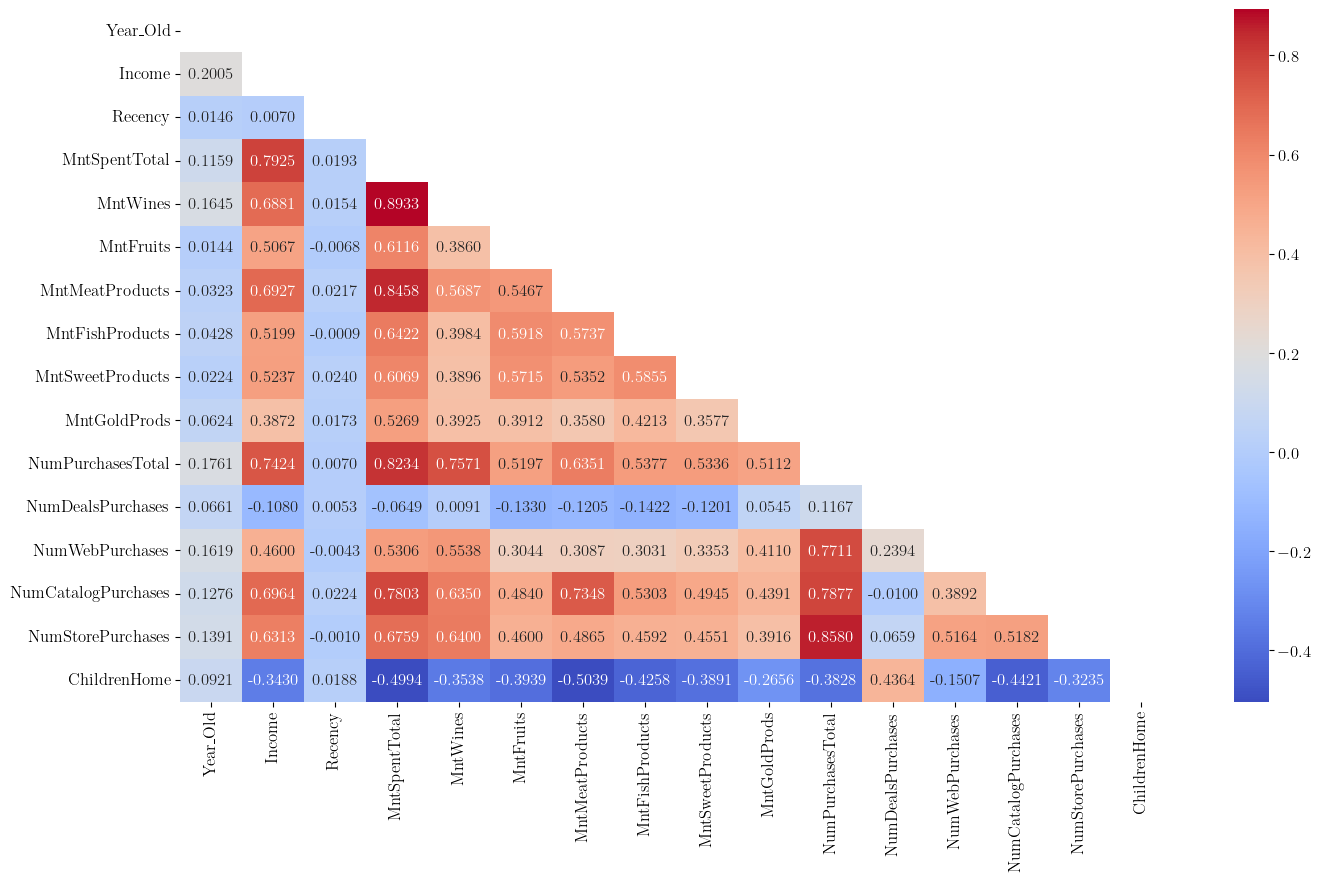

In [7]:
corr_matrix = data[int_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))

with plt.style.context(["seaborn-v0_8-colorblind",
                   "./mplstyle/basic.mplstyle",
                   #"./mplstyle/scatter.mplstyle",
                   ]):
    
    sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, mask=mask, fmt=".4f")
    plt.show()

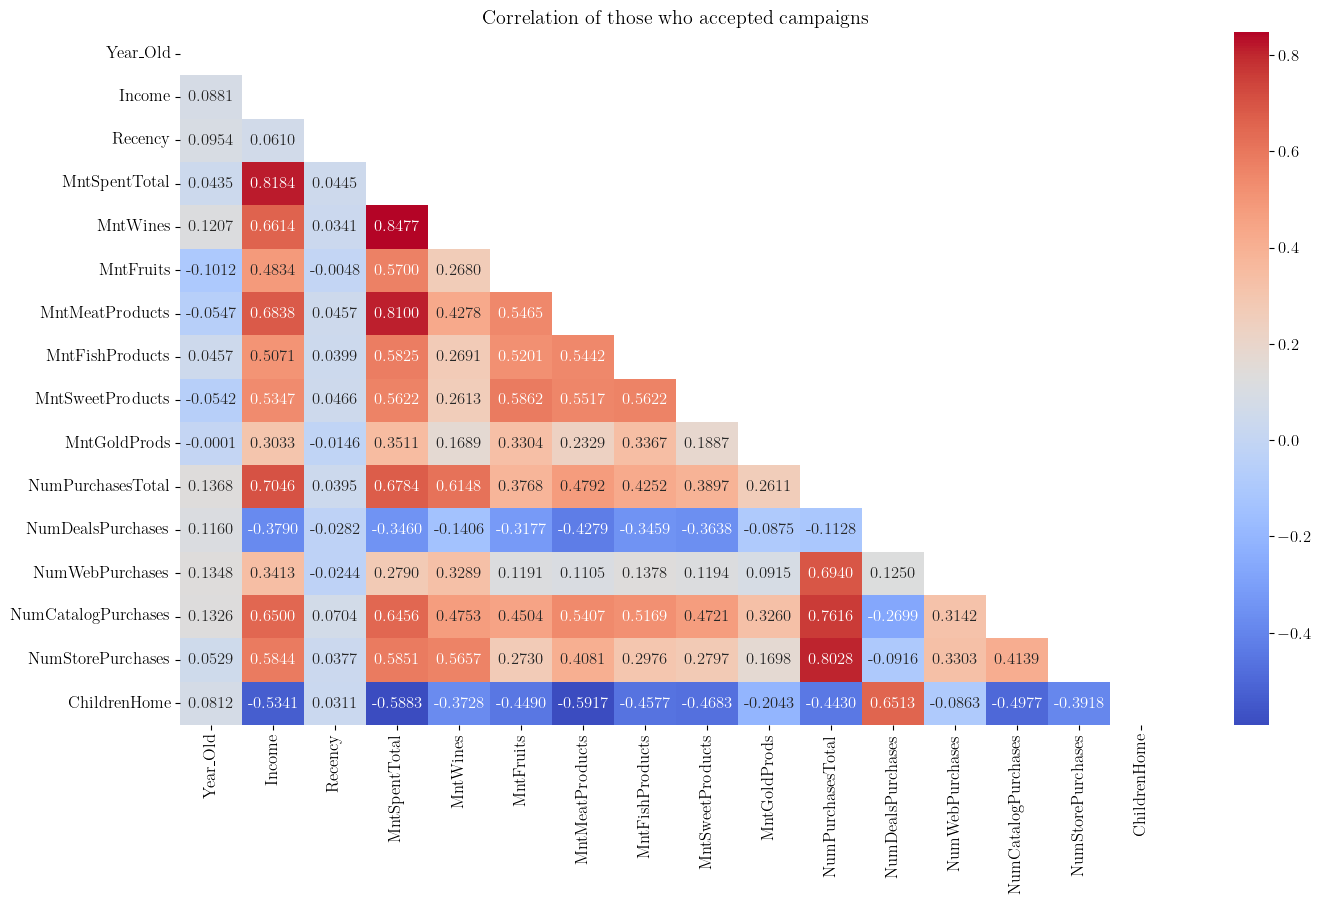

In [8]:
corr_matrix = data_ycmp[int_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))

with plt.style.context(["seaborn-v0_8-colorblind",
                   "./mplstyle/basic.mplstyle",
                   #"./mplstyle/scatter.mplstyle",
                   ]):
    
    sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, 
                mask=mask, fmt=".4f").set_title("Correlation of those "
                                                "who accepted campaigns")
    plt.show()

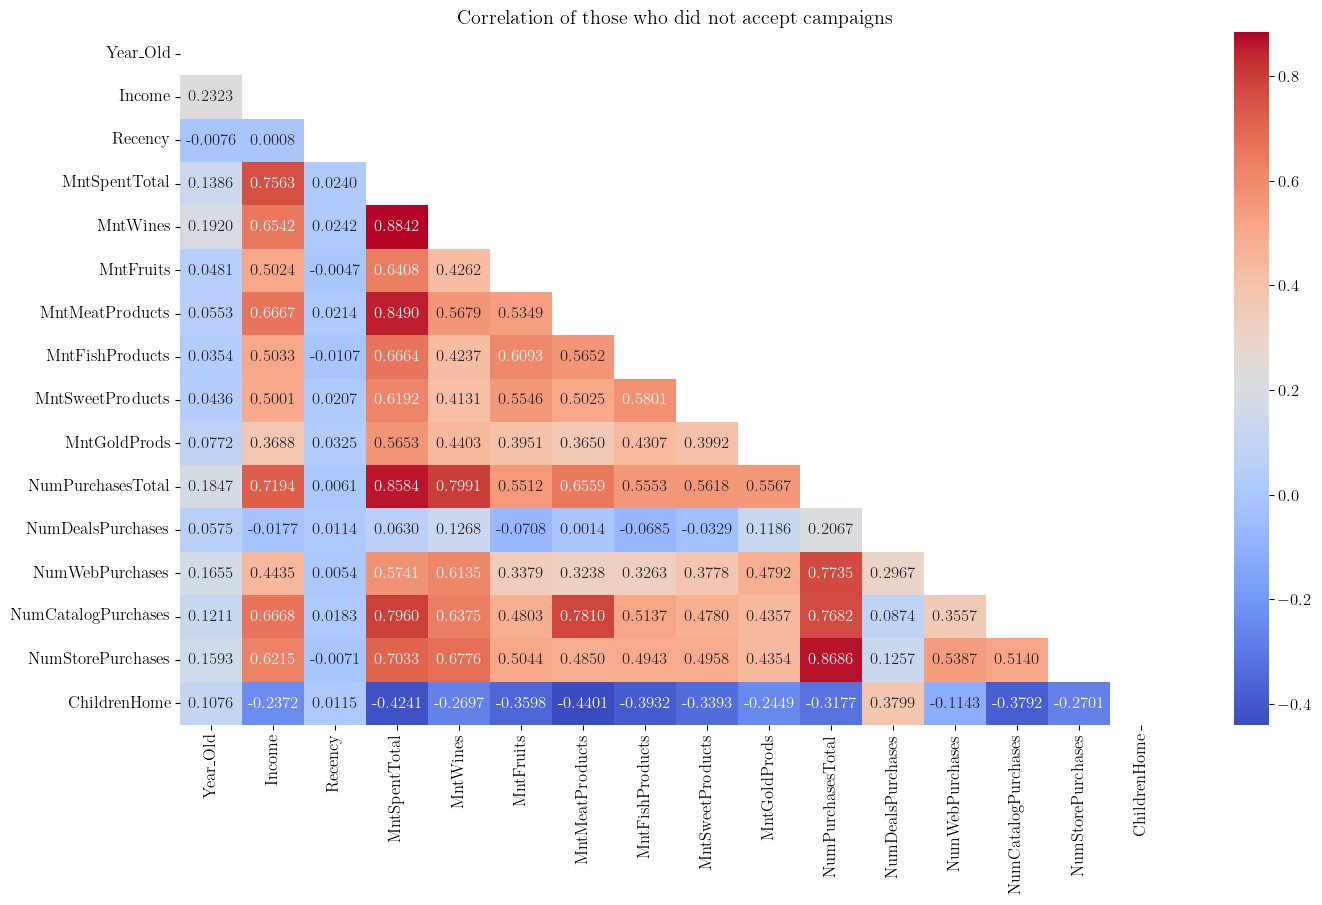

In [9]:
corr_matrix = data_ncmp[int_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))

with plt.style.context(["seaborn-v0_8-colorblind",
                   "./mplstyle/basic.mplstyle",
                   #"./mplstyle/scatter.mplstyle",
                   ]):
    
    sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, 
                mask=mask, fmt=".4f").set_title("Correlation of those who did "
                                                "not accept campaigns")
    plt.show()

## Comparisons

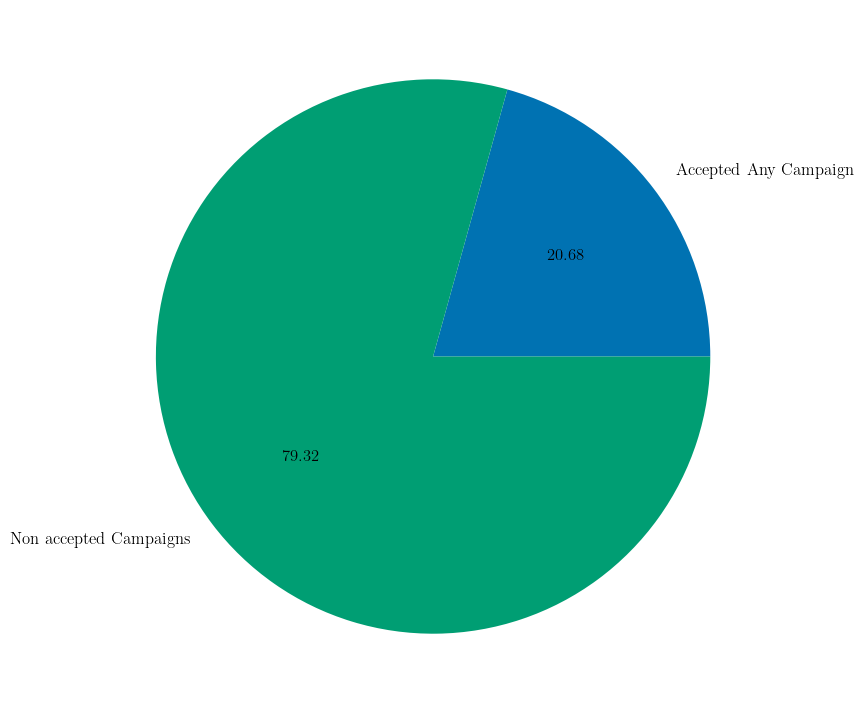

In [10]:
with plt.style.context(["seaborn-v0_8-colorblind",
                   "./mplstyle/basic.mplstyle",
                   "./mplstyle/scatter.mplstyle",
                   ]):

    fig, ax = plt.subplots()
    ax.pie([data_ycmp["ID"].count(), 
            data_ncmp["ID"].count()], 
            labels=["Accepted Any Campaign", "Non accepted Campaigns"],
            autopct='%1.2f%%',
            )
    plt.show();


In [11]:
# KS-Test and Levene on integer columns by campaign acceptance

int_cols = ["Year_Old", "Income", "Recency", "MntSpentTotal", "MntWines", 
            "MntFruits", "MntMeatProducts", "MntFishProducts",
            "MntSweetProducts", "MntGoldProds", "NumPurchasesTotal",
            "NumDealsPurchases", "NumWebPurchases", "NumCatalogPurchases", 
            "NumStorePurchases", "ChildrenHome"]

# KS
def ksfunc(col):
    return stats.kstest(col, stats.norm.cdf,
                        args=(col.mean(), col.std()))

results_y = data_ycmp[int_cols].apply(ksfunc)
results_n = data_ncmp[int_cols].apply(ksfunc)

results_ks = pd.concat([results_n, results_y], )

results_ks = results_ks.T
results_ks = results_ks.applymap(lambda x: f"{x:.4f}")
results_ks.columns = ["Statistic (y)", "p-Value (y)", 
                      "Statistic (n)", "p-Value (n)"]
results_ks.columns.names = ["KS-Test"]
results_ks.index.names = ["int_cols"]

# Levene
results = stats.levene(data_ycmp[int_cols], 
                       data_ncmp[int_cols], 
                       center="mean")
results_stats = pd.Series(results.statistic)
results_stats.index = int_cols
results_pvalue = pd.Series(results.pvalue)
results_pvalue.index = int_cols

results_lev = pd.concat([results_stats, results_pvalue], axis=1)
results_lev.columns = ["Statistic", "p-Value"]
results_lev.columns.names = ["Levene"]
results_lev.index.names = ["int_cols"]

results_lev = results_lev.map(lambda x: f"{x:.4f}")

# Combining frames
results = pd.concat([results_ks, results_lev], axis=1)
column_names = [("Ks-test", "Statistic (y)"), ("Ks-test", "p-Value (y)"), 
                ("Ks-test", "Statistic (n)"), ("Ks-test", "p-Value (n)"),
                ("Levene", "Statistic"), ("Levene", "p-Value")]
results.columns = pd.MultiIndex.from_tuples(column_names)

results

Ks-test                                        \
                    Statistic (y) p-Value (y) Statistic (n) p-Value (n)   
int_cols                                                                  
Year_Old                   0.0617      0.0000        0.0635      0.0483   
Income                     0.0466      0.0010        0.1010      0.0002   
Recency                    0.0698      0.0000        0.0887      0.0014   
MntSpentTotal              0.1779      0.0000        0.0704      0.0208   
MntWines                   0.1986      0.0000        0.0710      0.0191   
MntFruits                  0.2648      0.0000        0.2118      0.0000   
MntMeatProducts            0.2480      0.0000        0.1667      0.0000   
MntFishProducts            0.2572      0.0000        0.1987      0.0000   
MntSweetProducts           0.2666      0.0000        0.2080      0.0000   
MntGoldProds               0.2103      0.0000        0.1937      0.0000   
NumPurchasesTotal          0.1767      0.0000        0.1031      0.0001   
NumDealsPurchases          0.2423      0.0000        0.3002      0.0000   
NumWebPurchases            0.1690      0.0000        0.1024      0.0001   
NumCatalogPurchases        0.2245      0.0000        0.1063      0.0001   
NumStorePurchases          0.2073      0.0000        0.0933      0.0007   
ChildrenHome               0.2806      0.0000        0.3075      0.0000   

                       Levene          
                    Statistic p-Value  
int_cols                               
Year_Old               8.2130  0.0042  
Income                 0.0055  0.9407  
Recency                0.3926  0.5310  
MntSpentTotal         86.3006  0.0000  
MntWines             203.0794  0.0000  
MntFruits             24.2888  0.0000  
MntMeatProducts      151.9987  0.0000  
MntFishProducts       64.9998  0.0000  
MntSweetProducts      67.5303  0.0000  
MntGoldProds          41.8228  0.0000  
NumPurchasesTotal     23.0218  0.0000  
NumDealsPurchases      2.4770  0.1157  
NumWebPurchases        0.0167  0.8971  
NumCatalogPurchases   14.1206  0.0002  
NumStorePurchases      0.4095  0.5223  
ChildrenHome          18.3733  0.0000

### Mean group comparison

In [31]:
cols_tt = ["Income", "Recency", "NumDealsPurchases", 
           "NumWebPurchases", "NumStorePurchases"]

In [33]:
for col in cols_tt:

    results_ks1 = stats.kstest(data_ycmp[col], stats.norm.cdf,
                            args=(data_ycmp[col].mean(), 
                                    data_ycmp[col].std()))
    results_ks2 = stats.kstest(data_ncmp[col], stats.norm.cdf,
                            args=(data_ncmp[col].mean(), 
                                    data_ncmp[col].std()))
    results_lev = stats.levene(data_ycmp[col], data_ncmp[col])
    ttest = stats.ttest_ind(data_ycmp[col], data_ncmp[col])
    cohend = (data_ycmp[col].mean() - data_ncmp[col].mean()) / data[col].std()

    print(
        f"\t{col} comparison\n"
        "\nAccepted Campaign Group: "
        f"\n\tMean: {data_ycmp[col].mean():.3f}"
        f"\n\tStd: {data_ycmp[col].std():.3f}"
        f"\n\tKS (p): {results_ks1.pvalue:.3f}"
        "\nnon-Accepted Campaign Group: "
        f"\n\tMean: {data_ncmp[col].mean():.3f}"
        f"\n\tStd: {data_ncmp[col].std():.3f}"
        f"\n\tKS (p): {results_ks1.pvalue:.3f}"
        f"\n\nLevene: {results_lev.pvalue:.3f}"
        "\nT-Test: "
        f"\n\tStatistic: {ttest.statistic:.3f}"
        f"\n\tp-value: {ttest.pvalue:.3f}"
        f"\nCohen's D: {cohend:.3f}"
        "\n\n\t======\n"
    )

	Income comparison

Accepted Campaign Group: 
	Mean: 65249.292
	Std: 20285.501
	KS (p): 0.000
non-Accepted Campaign Group: 
	Mean: 48488.422
	Std: 20494.046
	KS (p): 0.000

Levene: 0.806
T-Test: 
	Statistic: 15.587
	p-value: 0.000
Cohen's D: 0.778


	Recency comparison

Accepted Campaign Group: 
	Mean: 48.096
	Std: 29.032
	KS (p): 0.001
non-Accepted Campaign Group: 
	Mean: 49.340
	Std: 28.922
	KS (p): 0.001

Levene: 0.533
T-Test: 
	Statistic: -0.817
	p-value: 0.414
Cohen's D: -0.043


	NumDealsPurchases comparison

Accepted Campaign Group: 
	Mean: 1.998
	Std: 1.760
	KS (p): 0.000
non-Accepted Campaign Group: 
	Mean: 2.405
	Std: 1.957
	KS (p): 0.000

Levene: 0.068
T-Test: 
	Statistic: -4.036
	p-value: 0.000
Cohen's D: -0.211


	NumWebPurchases comparison

Accepted Campaign Group: 
	Mean: 5.239
	Std: 2.600
	KS (p): 0.000
non-Accepted Campaign Group: 
	Mean: 3.784
	Std: 2.696
	KS (p): 0.000

Levene: 0.661
T-Test: 
	Statistic: 10.339
	p-value: 0.000
Cohen's D: 0.531


	NumStorePurchases co

### Robust group comparison

In [26]:
cols_umw = ["Year_Old", "MntSpentTotal", "MntWines", 
            "MntFruits", "MntMeatProducts", "MntFishProducts",
            "MntSweetProducts", "MntGoldProds", "NumPurchasesTotal",
            "NumCatalogPurchases", "ChildrenHome"]

In [37]:
for col in cols_umw:

    results_ks1 = stats.kstest(data_ycmp[col], stats.norm.cdf,
                            args=(data_ycmp[col].mean(), 
                                    data_ycmp[col].std()))
    results_ks2 = stats.kstest(data_ncmp[col], stats.norm.cdf,
                            args=(data_ncmp[col].mean(), 
                                    data_ncmp[col].std()))
    results_lev = stats.levene(data_ycmp[col], 
                            data_ncmp[col])
    ttest = stats.mannwhitneyu(data_ycmp[col], 
                            data_ncmp[col],
                            use_continuity=True)
    
    # Rank-Biserial's Wendt formula
    n1, n2 = len(data_ycmp[col]), len(data_ncmp[col])
    rbis = 1 - (2 * ttest.statistic) / (n1 * n2)

    print(
        f"\t{col} comparison\n"
        "\nAccepted Campaign Group: "
        f"\n\tMedian: {data_ycmp[col].median():.3f}"
        f"\n\tStd: {data_ycmp[col].std():.3f}"
        f"\n\tKS (p): {results_ks1.pvalue:.3f}"
        "\nnon-Accepted Campaign Group: "
        f"\n\tMedian: {data_ncmp[col].median():.3f}"
        f"\n\tStd: {data_ncmp[col].std():.3f}"
        f"\n\tKS (p): {results_ks1.pvalue:.3f}"
        f"\n\nLevene: {results_lev.pvalue:.3f}"
        "\nMann-Whitney U test: "
        f"\n\tStatistic: {ttest.statistic:.3f}"
        f"\n\tp-value: {ttest.pvalue:.3f}"
        f"\nRank-Biserial r: {rbis:.3f}"
        "\n\n\t=====\n"
    )

	Year_Old comparison

Accepted Campaign Group: 
	Median: 55.000
	Std: 12.514
	KS (p): 0.048
non-Accepted Campaign Group: 
	Median: 54.000
	Std: 11.469
	KS (p): 0.048

Levene: 0.004
Mann-Whitney U test: 
	Statistic: 416979.000
	p-value: 0.133
Rank-Biserial r: -0.046

	=====

	MntSpentTotal comparison

Accepted Campaign Group: 
	Median: 1153.500
	Std: 672.186
	KS (p): 0.021
non-Accepted Campaign Group: 
	Median: 257.000
	Std: 512.734
	KS (p): 0.021

Levene: 0.000
Mann-Whitney U test: 
	Statistic: 607506.500
	p-value: 0.000
Rank-Biserial r: -0.523

	=====

	MntWines comparison

Accepted Campaign Group: 
	Median: 603.000
	Std: 401.087
	KS (p): 0.019
non-Accepted Campaign Group: 
	Median: 104.000
	Std: 265.975
	KS (p): 0.019

Levene: 0.000
Mann-Whitney U test: 
	Statistic: 621951.500
	p-value: 0.000
Rank-Biserial r: -0.560

	=====

	MntFruits comparison

Accepted Campaign Group: 
	Median: 20.500
	Std: 45.017
	KS (p): 0.000
non-Accepted Campaign Group: 
	Median: 7.000
	Std: 37.867
	KS (p): 0

## Categorical comparison by group

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   ID                   2205 non-null   Int64          
 1   Year_Birth           2205 non-null   Int64          
 2   Year_Old             2205 non-null   Int64          
 3   CustomerFor          2205 non-null   timedelta64[ns]
 4   Dt_Customer          2205 non-null   datetime64[ns] 
 5   Education            2205 non-null   category       
 6   Marital_Status       2205 non-null   category       
 7   Income               2205 non-null   Int64          
 8   Kidhome              2205 non-null   Int64          
 9   Teenhome             2205 non-null   Int64          
 10  ChildrenHome         2205 non-null   Int64          
 11  Recency              2205 non-null   Int64          
 12  MntSpentTotal        2205 non-null   Int64          
 13  MntWines          

## Notebook Session

In [24]:
# Notebook info
process = psutil.Process()
memory_used = process.memory_info().rss / (1024 ** 2)  # MB

print(f"\n\tMemory used: {memory_used:.2f} MB\n")

sinfo(
    na=True,
    os=True,
    cpu=False,
    jupyter=True,
    std_lib=True,
    write_req_file=False,
)


	Memory used: 193.25 MB

-----
datetime    NA
json        2.0.9
matplotlib  3.8.4
numpy       1.26.4
pandas      2.2.2
pathlib     NA
psutil      6.0.0
scipy       1.14.0
seaborn     0.13.2
sinfo       0.3.1
warnings    NA
-----
IPython             8.26.0
jupyter_client      8.6.2
jupyter_core        5.7.2
-----
Python 3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:04:44) [MSC v.1940 64 bit (AMD64)]
Windows-10-10.0.19045-SP0
None
-----
Session information updated at 2024-07-18 14:17
